In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import ast
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

# Load Datasets

In [2]:
playlist = pd.read_parquet("../phase2_data_cleaning/cleaned dataset/playlist_cleaned.parquet")
track = pd.read_parquet("../phase2_data_cleaning/cleaned dataset/track_cleaned.parquet")

# Feature Creation for Playlist Dataset

### Correlation Check for Columns

Number of Tracks vs Number of Artists

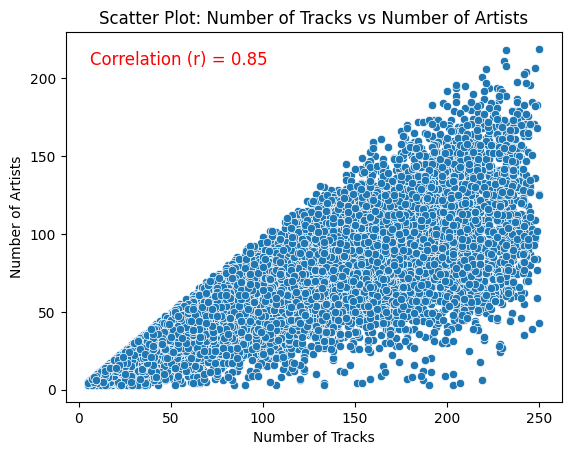

In [3]:
r_value, _ = pearsonr(playlist["num_tracks"], playlist["num_artists"])

# Create the scatter plot
sns.scatterplot(data=playlist, x="num_tracks", y="num_artists")

# Adding labels and title
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Artists')
plt.title('Scatter Plot: Number of Tracks vs Number of Artists')

# Annotate the plot with the r value
plt.text(0.05, 0.95, f'Correlation (r) = {r_value:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')

# Show the plot
plt.show()

Number of Tracks vs Number of Edits

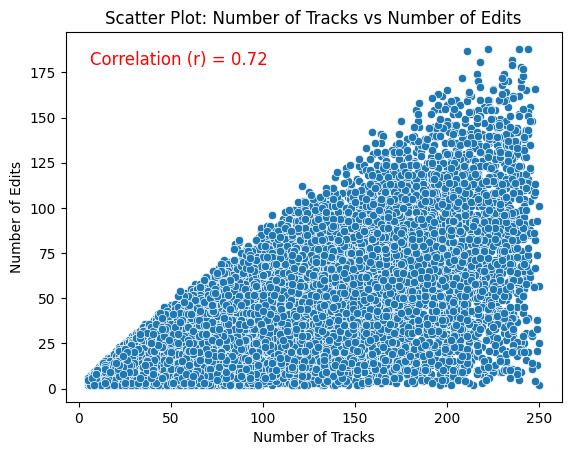

In [4]:
r_value, _ = pearsonr(playlist["num_tracks"], playlist["num_edits"])

# Create the scatter plot
sns.scatterplot(data=playlist, x="num_tracks", y="num_edits")

# Adding labels and title
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Edits')
plt.title('Scatter Plot: Number of Tracks vs Number of Edits')

# Annotate the plot with the r value
plt.text(0.05, 0.95, f'Correlation (r) = {r_value:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')

# Show the plot
plt.show()

As the there is a high correlation betwween number of tracks vs number of edits/artists, we will create new features that aggregates these features.

### Average Duration per Track

We are creating a new column to find out the average duration of tracks in the playlist to the nearest seconds.

In [5]:
playlist["avg_duration_per_track"] = playlist["total_duration"] // playlist["num_tracks"]

print(playlist[["total_duration", "avg_duration_per_track"]].head())

       total_duration  avg_duration_per_track
9728             2165                     154
18539            9077                     216
18511            4496                     224
18507           13380                     215
6210            22279                     301


### Average Tracks per Edit

We are creating a new column to find out the average number of songs added per edit (1 edit is whatever songs added in a 2-hours frame)

In [6]:
playlist["avg_tracks_per_edit"] = playlist["num_tracks"] / playlist["num_edits"]

playlist["avg_tracks_per_edit"] = playlist["avg_tracks_per_edit"].round(3)

print(playlist[["total_duration", "avg_tracks_per_edit"]].head())

       total_duration  avg_tracks_per_edit
9728             2165                1.273
18539            9077                2.800
18511            4496                6.667
18507           13380                4.429
6210            22279                3.524


### Shannon Entropy

The **Shannon entropy** formula is used to measure the diversity (in terms of artists) of a playlist:

$$
H(X) = - \sum_{i=1}^{n} p(x_i) \cdot \log_2(p(x_i))
$$

Where:
- $H(X)$ represents the artist diversity of the playlist.
- $p(x_i)$ represents the proportion of tracks that belong to a specific artist
- $n$ is the total number of unique artists in the playlist.

#### Application to our Playlists:
- Each track in the playlist is mapped to an `artist_idx`.
- The entropy quantifies the diversity of artists in the playlist.

Steps:
1. Map each track (`track_idx`) to its artist (`artist_idx`).
2. Count how many tracks each artist has.
3. Calculate the proportion of tracks per artist.
4. Apply the Shannon entropy formula to measure diversity.

#### Interpretation:
- **High $H(X)$**: More even distribution of tracks across multiple artists (higher diversity).
- **Low $H(X)$**: Tracks are concentrated among fewer artists (lower diversity).

This feature helps quantify the diversity of artists in playlists.


Creating a column that contains only the track_idx

In [7]:
# Convert the string to a dictionary and extract the list of track indices
playlist['track_idx_list'] = playlist['tracks'].apply(lambda track_str: 
    list(ast.literal_eval(track_str.replace("'", "\"")).values()) 
    if isinstance(track_str, str) else list(track_str.values())
)

# Output the result
print(playlist[['track_idx_list']].head())

                                          track_idx_list
9728   [55709, 5427, 52495, 157555, 235367, 126542, 8...
18539  [3689, 207774, 194775, 135193, 218011, 37844, ...
18511  [160375, 131195, 164629, 147280, 193891, 17077...
18507  [104436, 229428, 25968, 186871, 81592, 15947, ...
6210   [244173, 210510, 9349, 224202, 147251, 35498, ...


Coding the Shannon Entropy

In [8]:
# Ensure track_idx in track dataframe is an integer
track['track_idx'] = track['track_idx'].astype(int)

# Create a dictionary mapping track_idx to artist_idx from the track dataframe
track_artist_dict = dict(zip(track['track_idx'].astype(str), track['artist_idx']))

# Apply this dictionary to the track_idx_list in the playlist DataFrame
playlist['artist_idx_list'] = playlist['track_idx_list'].apply(
    lambda track_list: [track_artist_dict.get(str(track_idx), np.nan) for track_idx in track_list]
)

# Remove NaN artist_idx values (if any)
playlist['artist_idx_list'] = playlist['artist_idx_list'].apply(
    lambda x: [artist for artist in x if not pd.isna(artist)]
)

# Initialize a list to store Shannon entropy values
shannon_entropy_values = []

# Compute Shannon entropy for each playlist
for artist_idx_list in playlist['artist_idx_list']:
    if artist_idx_list:  # Skip empty playlists
        # Count how many tracks each artist has in the playlist
        artist_counts = pd.Series(artist_idx_list).value_counts()

        # Calculate the proportion of tracks for each artist
        total_tracks = len(artist_idx_list)
        proportions = artist_counts / total_tracks

        # Compute Shannon entropy
        entropy = -np.sum(proportions * np.log2(proportions))

        shannon_entropy_values.append(entropy)
    else:
        shannon_entropy_values.append(np.nan)

# Add Shannon entropy values as a new column in the playlist dataframe
playlist['artist_diversity'] = shannon_entropy_values

# Output the result
print(playlist[['artist_diversity']].head())

       artist_diversity
9728           2.128085
18539          5.136249
18511          4.321928
18507          5.760648
6210           5.004921


### Track Weight Assignment
Based on `num_edits` and `num_tracks`

We believe that the more recently added tracks to the playlist is a better representation of the user's preference. As such, we would be assigning weights for each tracks in the playlist. 
<br>
<br>
The creation of the weights follows this process:
<br>
<br>
1. **Triangular Number Formula for Total Weight Sum**:
   To compute the total weight sum for the edits, the triangular number formula is used:
   $$
   \text{Total Weight Sum} = \sum_{i=1}^{n} i = \frac{n(n+1)}{2}
   $$
   where $n$ is the number of edits (`num_edits`). This sum represents the cumulative weight over all edits.
<br>
<br>
2. **Track Distribution**:

   - **Base Tracks per Edit**: Each edit is assigned an equal number of tracks, computed as:
     $$
     \text{Base tracks per edit} = \left\lfloor \frac{\text{num\_tracks}}{\text{num\_edits}} \right\rfloor
     $$
   - **Extra Tracks**: The remaining tracks, calculated as:
     $$
     \text{extra tracks} = {\text{num\_tracks}}\;  \% \;{\text{num\_edits}}
     $$
     These extra tracks are distributed by adding 1 track to the most recent edit.
<br>
<br>
3. **Weight per Edit**:
   The weight for each edit is calculated as:
   $$
   \text{track\_weight} = \frac{\text{edit\_weight}[i]}{\text{batch\_size}}
   $$
   where $i$ is the index of the edit (starting from 0).
<br>
<br>
4. **Weight Assignment to Tracks**:
   For each edit, the weight is distributed among the tracks:
   $$
   \text{track\_weight} = \frac{\text{edit\_weight}[i]}{\text{batch\_size}}
   $$
   where `batch_size` is the number of tracks in the current edit. Each track gets a weight that is rounded to 5 decimal places.
<br>
<br>
5. **Result**:
   The final output is a list of tuples where each tuple contains a track and its corresponding weight. This list is added as a new column `tracks_weights_5dp` in the playlist DataFrame.


Example

- A playlist contains 16 tracks, and num_edit is 3.

- Using the Triangular Number Formula, the total_weight_sum is 6, which would be the denominator for the weight of each batch.

- The tracks are distributed in this way: The first edit had 5 songs, second edit had 5 songs, and the third edit had 6 songs. 

    - The weight for the first edit batch is $\frac{1}{6}$, since the index of this edit is 1

    - The weight for the second edit batch is $\frac{2}{6}$, since the index of this edit is 2

    - The weight for the third edit batch is $\frac{3}{6}$, since the index of this edit is 3

- For each individual tracks in the batch, we would have to do a further division by the number of tracks in the batch

    - The individual weights for the tracks in the first batch (with 5 tracks) is $\frac{1}{6\times5} = \frac{1}{30}$

    - The individual weights for the tracks in the second batch (with 5 tracks) is $\frac{2}{6\times5} = \frac{1}{15}$

    - The individual weights for the tracks in the third batch (with 6 tracks) is $\frac{3}{6\times6} = \frac{1}{12}$

- Summing up the weights for each individual tracks, $(5 \times \frac{1}{30}) + (5 \times \frac{1}{15}) + (6 \times \frac{1}{12}) = 1$

There are a few rows where the num_edits == num_tracks + 1, and to prevent division by zero error, we will identify those rows, and subtract 1 from the num_edits such that the average tracks per edit is 1

In [9]:
# Check for rows where num_edits > num_tracks
rows_with_more_edits_than_tracks = playlist[playlist['num_edits'] > playlist['num_tracks']]

# Print out the rows that satisfy the condition (this is optional, for inspection)
print("Before changes:")
print(rows_with_more_edits_than_tracks[['playlist_idx', 'num_edits', 'num_tracks', 'avg_tracks_per_edit']].head())

# Store the original index (track_idx) for later retrieval
track_idx_before_change = rows_with_more_edits_than_tracks['playlist_idx'].values

# Modify 'avg_tracks_per_edit' for the rows where num_edits > num_tracks
playlist.loc[playlist['num_edits'] > playlist['num_tracks'], 'avg_tracks_per_edit'] = 1

# Now adjust num_edits column by subtracting 1 for the rows where num_edits > num_tracks
playlist['num_edits'] = playlist.apply(
    lambda row: row['num_edits'] - 1 if row['num_edits'] > row['num_tracks'] else row['num_edits'],
    axis=1
)

# After the changes, retrieve the rows using the stored track_idx
rows_with_more_edits_than_tracks_after = playlist[playlist['playlist_idx'].isin(track_idx_before_change)]

# Print out the rows after changes for comparison
print("After changes:")
print(rows_with_more_edits_than_tracks_after[['playlist_idx', 'num_edits', 'num_tracks', 'avg_tracks_per_edit']].head())

Before changes:
       playlist_idx  num_edits  num_tracks  avg_tracks_per_edit
14773           397          7           6                0.857
10067          2038          7           6                0.857
2142           2408          8           7                0.875
4266           4021         12          11                0.917
6174           4223         11          10                0.909
After changes:
       playlist_idx  num_edits  num_tracks  avg_tracks_per_edit
14773           397          6           6                  1.0
10067          2038          6           6                  1.0
2142           2408          7           7                  1.0
4266           4021         11          11                  1.0
6174           4223         10          10                  1.0


Code for the Algorithm

In [10]:
track_weights_list = []

for index, row in playlist.iterrows():
    num_tracks = row['num_tracks']
    num_edits = row['num_edits']
    tracks = ast.literal_eval(row['tracks'])  # Convert the string to a dictionary
    
    # Compute total weight sum (Triangular number formula) without adding it to the DataFrame
    total_weight_sum = num_edits * (num_edits + 1) / 2
    
    # Calculate base tracks per edit and extra tracks without adding them to the DataFrame
    base_tracks_per_edit = num_tracks // num_edits
    extra_tracks = num_tracks % num_edits
    
    track_distribution = [base_tracks_per_edit] * num_edits
    for i in range(extra_tracks):
        track_distribution[-(i + 1)] += 1  # Give extra tracks to most recent edits
    
    edit_weights = [(i + 1) / total_weight_sum for i in range(num_edits)]
    
    track_weights = []
    track_pos = 0  # Track index in the playlist
    
    for edit_idx, batch_size in enumerate(track_distribution):
        batch_weight = edit_weights[edit_idx]
        track_weight = batch_weight / batch_size  # Weight per track in batch
        
        # Round the track weight to 5 decimal places
        track_weight = round(track_weight, 5)
        
        for _ in range(batch_size):
            track_key = str(track_pos)  # Convert track_pos to string to match dictionary key format
            if track_key in tracks:  # Access track using string keys
                track_weights.append((tracks[track_key], track_weight))  # Add track and its weight
            track_pos += 1
    
    track_weights_list.append(track_weights)

# Add the list of track weights as a new column in the DataFrame
playlist['tracks_weights_5dp'] = track_weights_list

# Output the result
print(playlist[['num_tracks', 'num_edits', 'tracks_weights_5dp']].head())

       num_tracks  num_edits  \
9728           14         11   
18539          42         15   
18511          20          3   
18507          62         14   
6210           74         21   

                                      tracks_weights_5dp  
9728   [(55709, 0.01515), (5427, 0.0303), (52495, 0.0...  
18539  [(3689, 0.00417), (207774, 0.00417), (194775, ...  
18511  [(160375, 0.02778), (131195, 0.02778), (164629...  
18507  [(104436, 0.00238), (229428, 0.00238), (25968,...  
6210   [(244173, 0.00144), (210510, 0.00144), (9349, ...  


Checking to ensure that the sum of the weights approximately equal to 1

In [11]:
# Calculate the sum of weights for each row
weights_sums = [sum(weight for _, weight in track_weights) for track_weights in playlist['tracks_weights_5dp']]

# Get the minimum and maximum sum of weights
min_weight_sum = min(weights_sums)
max_weight_sum = max(weights_sums)

# Print the range of the sum of weights
print(f"Range of weight sums: Min = {min_weight_sum}, Max = {max_weight_sum}")

Range of weight sums: Min = 0.9994300000000015, Max = 1.0005499999999974


### Embedding the Name of the Playlist 

We are embedding the names of the playlists because we believe the names can help to segment different groups of playlists.

For the similarity of the playlist names to be meaningful, it is crucial to capture the semantic meaning of the words in context, rather than relying on exact word matches (e.g., "workout" and "gym" often appear in similar contexts).

To achieve this, we are utilizing pre-trained Word2Vec models to embed each word in the playlist names into a 200-dimensional vector. This allows us to effectively represent the playlists in a way that reflects their context and meaning, facilitating more accurate similarity analysis and grouping

Embedding the words using `glove-wiki-gigaword-200` model

In [12]:
word2vec_model = api.load("glove-wiki-gigaword-200")

def get_word2vec_embedding(name, model):
    # Tokenize the name (split into words)
    words = name.split()
    
    # Get the word vector for each word in the name
    word_vectors = []
    for word in words:
        try:
            word_vector = model[word]  # Get the word embedding from the pre-trained model
            word_vectors.append(word_vector)
        except KeyError:
            # If the word is not in the model's vocabulary, skip it (or handle it as you prefer)
            continue
    
    # If there are word vectors, return the mean; otherwise, return a zero vector
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Mean of word vectors for the name
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no valid word vectors

# Assuming 'playlist' is your DataFrame with the 'name' column
playlist['name_embeddings'] = playlist['name'].apply(lambda x: get_word2vec_embedding(x, word2vec_model))

# Check the resulting embeddings
print(playlist[['name', 'name_embeddings']].head())

            name                                    name_embeddings
9728     mixtape  [-0.63461, -0.22082, -0.46144, -0.37144, 0.274...
18539   fall '17  [0.16699, -0.080175, -0.27222, -0.34137, -0.16...
18511  HALLOWEEN  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
18507        90s  [-0.32666, -0.15259, -0.22385, 0.49504, 0.0226...
6210     Me Like  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


Verifying the results of the embeddings

In [13]:
# Function to find most similar playlists using precomputed embeddings
def find_most_similar_playlist(target_name, playlist_df):
    # Get the embedding for the target name
    target_embedding = playlist_df.loc[playlist_df['name'] == target_name, 'name_embeddings'].values[0]
    
    # Compute cosine similarity with each playlist's embedding
    playlist_df['similarity'] = playlist_df['name_embeddings'].apply(
        lambda x: cosine_similarity([target_embedding], [x])[0][0]
    )
    
    # Filter out exact matches (similarity = 1) by excluding similarity of exactly 1
    playlist_df_filtered = playlist_df[playlist_df['similarity'] < 0.99]
    
    # Sort by similarity in descending order and return the top 10 most similar playlists
    similar_playlists = playlist_df_filtered[['name', 'similarity']].sort_values(by='similarity', ascending=False)
    
    # Return the top 10 similar playlists
    return similar_playlists.head(10)

target_name = "workout"
top_10_similar_playlists = find_most_similar_playlist(target_name, playlist)
print(top_10_similar_playlists)

                    name  similarity
14898          workouts     0.840002
9957            workouts    0.840002
19667        workout mix    0.798257
10627        workout mix    0.798257
15789  workout playlist     0.764424
15854   workout playlist    0.764424
9265         new workout    0.759134
399          rap workout    0.750562
18129        rap workout    0.750562
15653          workout 2    0.728444


### Popularity Mean & Variance

The population mean will be used to represent the average popularity of tracks within a playlist. It helps to provide an overall sense of how popular the tracks are on average in the playlist. <br> <br>
The population variance will be used to assess the diversity or uniformity of the tracks in terms of popularity. A high variance indicates that there are tracks in the playlist with highly different popularity values, whereas a low variance suggests that most tracks have similar popularity.
<br> <br>
For example, a playlist (A) could have a popularity mean of 50, and population variance of 100. Whereas another playlist (B) could also have a popularity mean of 50, but the population variance is 10. From this, we can infer that playlist A does not have much consideration in the popularity of the tracks, whereas the playlist B consistently chooses tracks that have a similar popularity.

In [14]:
# Ensure track_idx in track dataframe is an integer
track['track_idx'] = track['track_idx'].astype(int)

# Create a dictionary mapping track_idx to popularity from the track dataframe
track_popularity_dict = dict(zip(track['track_idx'].astype(str), track['track_popularity']))

# Apply this dictionary to the track_idx_list in the playlist DataFrame
playlist['track_popularity_list'] = playlist['track_idx_list'].apply(
    lambda track_list: [track_popularity_dict.get(str(track_idx), np.nan) for track_idx in track_list]
)

# Remove NaN popularity values (if any)
playlist['track_popularity_list'] = playlist['track_popularity_list'].apply(
    lambda x: [popularity for popularity in x if not pd.isna(popularity)]
)

# Initialize lists to store mean and variance values
popularity_mean_values = []
popularity_variance_values = []

# Compute mean and variance for each playlist
for popularity_list in playlist['track_popularity_list']:
    if popularity_list:  # Skip empty playlists
        # Compute mean and variance for the track_popularity values in the playlist
        mean_popularity = np.mean(popularity_list)
        variance_popularity = np.var(popularity_list)

        popularity_mean_values.append(mean_popularity)
        popularity_variance_values.append(variance_popularity)
    else:
        popularity_mean_values.append(np.nan)
        popularity_variance_values.append(np.nan)

# Add mean and variance values as new columns in the playlist dataframe
playlist['popularity_mean'] = popularity_mean_values
playlist['popularity_var'] = popularity_variance_values

playlist['popularity_mean'] = playlist['popularity_mean'].round(3)
playlist['popularity_var'] = playlist['popularity_var'].round(2)

# Output the result
print(playlist[['popularity_mean', 'popularity_var']].head())

       popularity_mean  popularity_var
9728            24.571          658.67
18539           42.357          834.42
18511           51.450          300.85
18507           48.016          776.50
6210            44.514          365.06


### Era of Tracks

Using the `era` column from the `track` table, we will calculate the proportion of tracks from each era in the playlist. 

In [15]:
# Create a dictionary mapping track_idx to era from the track dataframe
track_era_dict = dict(zip(track['track_idx'].astype(str), track['era']))

# Apply the era dictionary to the track_idx_list in the playlist DataFrame
playlist['track_era_list'] = playlist['track_idx_list'].apply(
    lambda track_list: [track_era_dict.get(str(track_idx), np.nan) for track_idx in track_list]
)

# Remove NaN era values (if any)
playlist['track_era_list'] = playlist['track_era_list'].apply(
    lambda x: [era for era in x if not pd.isna(era)]
)

# Initialize a list to store era counts for each playlist
era_count_values = []

# Compute the count of each era for each playlist
for era_list in playlist['track_era_list']:
    if era_list:  # Skip empty playlists
        era_counts = pd.Series(era_list).value_counts().to_dict()  # Count the occurrences of each era
        era_count_values.append(era_counts)
    else:
        era_count_values.append({})  # Empty dictionary if no tracks

# Add the era counts as a new column in the playlist dataframe
playlist['era_count'] = era_count_values

# Get a list of all unique eras (keys from the era_count dictionary)
all_eras = set()
for era_dict in era_count_values:
    all_eras.update(era_dict.keys())
all_eras = list(all_eras)

# Create a column for each era with the corresponding count and proportions
for era in all_eras:
    # Create a new column for the count of the era
    playlist[era + '_count'] = playlist['era_count'].apply(lambda x: x.get(era, 0))
    
    # Calculate the proportion for each era
    playlist[era + '_proportion'] = playlist[era + '_count'] / playlist['track_idx_list'].apply(len)

# Rename columns to lowercase with underscores instead of spaces
playlist.columns = [col.replace(' ', '_').lower() for col in playlist.columns]

# Output the result
print(playlist[['playlist_idx'] + [col for col in playlist.columns if 'proportion' in col]].head())

       playlist_idx  golden_era_proportion  2000s_proportion  \
9728              0               0.000000          0.000000   
18539             1               0.000000          0.000000   
18511             2               0.200000          0.200000   
18507             3               0.467742          0.290323   
6210              4               0.000000          0.067568   

       early_years_proportion  classic_era_proportion  modern_era_proportion  
9728                      0.0                0.000000               1.000000  
18539                     0.0                0.000000               1.000000  
18511                     0.0                0.450000               0.150000  
18507                     0.0                0.209677               0.032258  
6210                      0.0                0.000000               0.932432  


### Length of Tracks

Using the `category` column from the `track` table, we will calculate the proportion of tracks from of different lengths in the playlist. 

In [16]:
# Create a dictionary mapping track_idx to category from the track dataframe
track_category_dict = dict(zip(track['track_idx'].astype(str), track['category']))

# Apply the category dictionary to the track_idx_list in the playlist DataFrame
playlist['track_category_list'] = playlist['track_idx_list'].apply(
    lambda track_list: [track_category_dict.get(str(track_idx), np.nan) for track_idx in track_list]
)

# Remove NaN category values (if any)
playlist['track_category_list'] = playlist['track_category_list'].apply(
    lambda x: [category for category in x if not pd.isna(category)]
)

# Initialize a list to store category counts for each playlist
category_count_values = []

# Compute the count of each category for each playlist
for category_list in playlist['track_category_list']:
    if category_list:  # Skip empty playlists
        category_counts = pd.Series(category_list).value_counts().to_dict()  # Count the occurrences of each category
        category_count_values.append(category_counts)
    else:
        category_count_values.append({})  # Empty dictionary if no tracks

# Add the category counts as a new column in the playlist dataframe
playlist['category_count'] = category_count_values

# Get a list of all unique categories (keys from the category_count dictionary)
all_categories = set()
for category_dict in category_count_values:
    all_categories.update(category_dict.keys())
all_categories = list(all_categories)

# Create a column for each category with the corresponding count and proportions
category_proportion_columns = []  

# Create a column for each category with the corresponding count and proportions
for category in all_categories:
    category_lower = category.lower()

    # Create a new column for the count of the category
    playlist[category_lower + '_count'] = playlist['category_count'].apply(lambda x: x.get(category, 0))
    
    # Calculate the proportion for each category
    playlist[category_lower + '_proportion'] = playlist[category_lower + '_count'] / playlist['track_idx_list'].apply(len)

    # Append the proportion column name to the list
    category_proportion_columns.append(category_lower + '_proportion')

# Output the result
print(playlist[['playlist_idx'] + category_proportion_columns].head())

       playlist_idx  short_proportion  medium_proportion  long_proportion
9728              0          0.571429           0.428571         0.000000
18539             1          0.095238           0.714286         0.190476
18511             2          0.200000           0.350000         0.450000
18507             3          0.241935           0.516129         0.241935
6210              4          0.000000           0.324324         0.675676


# Saving the features for playlist

In [18]:
playlist['tracks_weights_5dp'] = playlist['tracks_weights_5dp'].apply(
    lambda x: str(x) if isinstance(x, list) else x  
)

playlist['name_embeddings'] = playlist['name_embeddings'].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else x  
)

columns_to_save = [
    'playlist_idx', 'name', 'name_embeddings', 'num_tracks', 
    'track_idx_list', 'tracks_weights_5dp', 'num_albums', 
    'num_edits', 'avg_tracks_per_edit', 'num_artists', 
    'artist_diversity', 'total_duration', 'avg_duration_per_track',
    'popularity_mean', 'popularity_var',
    'early_years_proportion', 'classic_era_proportion', 'golden_era_proportion', '2000s_proportion', 'modern_era_proportion',
    'short_proportion', 'medium_proportion', 'long_proportion'
]

df_to_save = playlist[columns_to_save]
df_to_save.to_parquet('feature engineered datasets/playlist.parquet', index=False)